In [9]:
import tensorflow as tf
from keras import layers
from keras import models
from keras.layers import Activation,BatchNormalization
import keras
from keras import layers
from keras import models
from keras.models import Model
import numpy as np

In [2]:
#Устанавливаем всеми путями одинаковый рандом стейт для сравнения нормализаций в равных условиях


seed_value= 0

import os
os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)


In [3]:
class BatchNorm(keras.layers.Layer):
    def __init__(self,):
        super(BatchNorm, self).__init__()     
        
    def build(self, input_shape):
        initializ_one= tf.keras.initializers.Ones()
        initializ_zero=tf.keras.initializers.Zeros()
        
        self.betta = self.add_weight(initializer=initializ_zero,trainable=True,dtype='float32')
        self.gamma = self.add_weight(initializer=initializ_one, trainable=True,dtype='float32')
        self.running_mean = tf.Variable(initial_value=initializ_zero(shape=input_shape[1:],dtype='float32'),trainable=False)
        self.running_var = tf.Variable(initial_value=initializ_zero(shape=input_shape[1:],dtype='float32'),trainable=False)
        
    def call(self, inputs, eps=1e-5, training=None,momentum = 0.9):
        
        if training:
            sample_mean,sample_var = tf.nn.moments(inputs,axes = 0)
            self.running_mean.assign(momentum * self.running_mean + (1 - momentum) * sample_mean)
            self.running_var.assign(momentum * self.running_var + (1 - momentum) * sample_var)
    
            std = tf.sqrt(sample_var + eps)
            x_centered = inputs - sample_mean
            x_norm = x_centered / std
            out = self.gamma * x_norm + self.betta
        
        elif not training:
            x_norm = (inputs - self.running_mean) / tf.sqrt(self.running_var + eps)
            out = self.gamma * x_norm + self.betta
        else:
            raise ValueError('Invalid forward batchnorm mode')
        return out

In [10]:
# Модель из статьи  https://arxiv.org/pdf/1701.02620.pdf

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1))) #нужно поэкспериментировать с размерами
# model.add(BatchNorm())
# model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
# model.add(BatchNorm())
# model.add(BatchNormalization())
model.add(layers.AveragePooling2D((2, 2)))
# model.add(layers.Conv2D(64, (5, 5), activation='relu'))
# model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          25632     
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [5]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [7]:
# Здесь можно брать данные с аугментацией из генераторов при необходимости

# import os
# from tensorflow.keras import optimizers
# from keras.preprocessing.image import ImageDataGenerator
# root = r'C:\\Users\\vinte\\Desktop\\MAIN\\Work_bench\\Тестовое VicueSoft\\downloads4\\'
# train_dir = os.path.join(root,"train\\")
# test_dir = os.path.join(root,"test\\")
# pool_companies= "Nike Coca-cola Adidas Apple Google Intel McDonalds Pepsi RedBull Yahoo".split()

# model.compile(loss = "categorical_crossentropy",optimizer=optimizers.RMSprop(lr=1e-4),metrics = ["acc"])

# train_datagen = ImageDataGenerator(rescale=1./255,rotation_range= 10, width_shift_range = 0.2,height_shift_range=0.2,
# shear_range=0.2, zoom_range=0.2,)
# # test_datagen = ImageDataGenerator(rescale=1./255)
# train_generator = train_datagen.flow_from_directory(train_dir,color_mode='grayscale', target_size=(28,28),batch_size=20,class_mode ='categorical')
# validation_generator = test_datagen.flow_from_directory(test_dir, color_mode='grayscale',target_size=(28,28),batch_size=20,class_mode ='categorical')

In [6]:
#Загружаем данные mnist, делим на выборки, компилируем модель
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
model.compile(optimizer='rmsprop',
 loss='categorical_crossentropy',
 metrics=['accuracy'])


In [6]:
train_images.shape

(60000, 28, 28, 1)

In [6]:
#Обучение без нормализаций 
history = model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 15s 11ms/step - loss: 0.2567 - accuracy: 0.9198
Epoch 2/5
938/938 [==============================] - 11s 12ms/step - loss: 0.0874 - accuracy: 0.9733
Epoch 3/5
938/938 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9794 ETA: 0s - loss: 0.066 - 9s 10ms/step - loss: 0.0668 - accuracy: 0.9794
Epoch 4/5
938/938 [==============================] - 9s 9ms/step - loss: 0.0573 - accuracy: 0.9822
Epoch 5/5
938/938 [==============================] - 9s 10ms/step - loss: 0.0513 - accuracy: 0.9846


In [8]:
#Тестирование без нормализаций
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.0241 - accuracy: 0.9918


In [7]:
#Обучение с кастомной нормализацией после 2 сверточных слоев 
history = model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 32s 29ms/step - loss: 0.1505 - accuracy: 0.9546
Epoch 2/5
938/938 [==============================] - 27s 29ms/step - loss: 0.0723 - accuracy: 0.9781
Epoch 3/5
938/938 [==============================] - 26s 28ms/step - loss: 0.0566 - accuracy: 0.98290s - loss: 0.0565 - accura
Epoch 4/5
938/938 [==============================] - 27s 29ms/step - loss: 0.0500 - accuracy: 0.98420s - loss: 0.0503 - 
Epoch 5/5
938/938 [==============================] - 24s 26ms/step - loss: 0.0461 - accuracy: 0.9859


In [8]:
#Обучение с кстомной нормализацией после 2 сверточных слоев
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 2s 6ms/step - loss: 0.0283 - accuracy: 0.9918


In [7]:
#Со стондартной нормолизацией после 2 сверточных слоев 
history = model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 15s 12ms/step - loss: 0.1417 - accuracy: 0.9567
Epoch 2/5
938/938 [==============================] - 12s 12ms/step - loss: 0.0644 - accuracy: 0.9807
Epoch 3/5
938/938 [==============================] - 12s 13ms/step - loss: 0.0510 - accuracy: 0.9841
Epoch 4/5
938/938 [==============================] - 13s 14ms/step - loss: 0.0440 - accuracy: 0.9870
Epoch 5/5
938/938 [==============================] - 11s 12ms/step - loss: 0.0402 - accuracy: 0.9877


In [8]:
#Со стондартной нормолизацией после 2 сверточных слоев 
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 2s 5ms/step - loss: 0.0279 - accuracy: 0.9920


In [16]:
# Обучение с генератором данных 
# history = model.fit_generator(train_generator,steps_per_epoch=100,epochs=20,validation_data=validation_generator,validation_steps = 50)

H:\Anaconda3\envs\VicueSoft_gpu\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 [==============================] - 4s 30ms/step - loss: 1.5972 - accuracy: 0.6440 - val_loss: 0.1726 - val_accuracy: 0.9610
Epoch 2/20
100/100 [==============================] - 3s 28ms/step - loss: 0.8839 - accuracy: 0.7135 - val_loss: 0.0390 - val_accuracy: 0.9890
Epoch 3/20
100/100 [==============================] - 3s 28ms/step - loss: 0.7067 - accuracy: 0.7695 - val_loss: 0.0585 - val_accuracy: 0.9850
Epoch 4/20
100/100 [==============================] - 3s 26ms/step - loss: 0.6017 - accuracy: 0.8080 - val_loss: 0.0982 - val_accuracy: 0.9800
Epoch 5/20
100/100 [==============================] - 3s 26ms/step - loss: 0.5196 - accuracy: 0.8405 - val_loss: 0.0708 - val_accuracy: 0.9860
Epoch 6/20
100/100 [==============================] - 3s 26ms/step - loss: 0.4600 - accuracy: 0.8605 - val_loss: 0.0759 - val_accuracy: 0.9790
Epoch 7/20
100/100 [==============================] - 3s 27ms/step - loss: 0.4416 - accuracy: 0.8570 - val_loss: 0.1275 - val_accuracy: 0.9720

KeyboardInterrupt: 

No handles with labels found to put in legend.


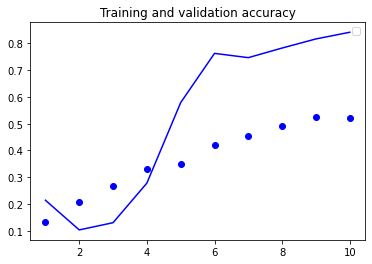

<Figure size 432x288 with 0 Axes>

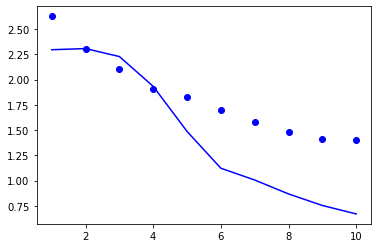

In [15]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss=history.history['val_loss']

epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,"bo")
plt.plot(epochs, val_acc,'b')
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.show()
plt.plot(epochs, loss,"bo")
plt.plot(epochs, val_loss, 'b')
plt.show()